In [1]:
REQUEST_ID = 1011
AOI = 'POLYGON ((-94.74437712304278 42.10688312211514, -94.78351591698579 42.10713783113902, -94.78351591698579 42.13795006926095, -94.74437712304278 42.13756819109344, -94.74437712304278 42.10688312211514))'
START_DATE = '2020-07-07'
END_DATE = '2020-07-14'

In [2]:
# !pip3 install -q tslearn

In [3]:
import os
import shutil
import json
import time
import cv2
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio.mask
import shapely

from tqdm.notebook import tqdm
from os.path import join, basename, split
from scipy.ndimage import rotate
from rasterio import features
from rasterio.merge import merge
from rasterio.warp import (aligned_target,
                           calculate_default_transform,
                           reproject,
                           Resampling)
from shapely.geometry import Polygon, shape, LinearRing, box
import shapely.wkt
from pathlib import Path
from datetime import datetime
import matplotlib.pylab as plt
import seaborn as sns

#from tslearn.clustering import TimeSeriesKMeans
#from tslearn.utils import to_time_series_dataset
import rasterio.mask as riomask

from code.download.utils import get_tiles, _check_folder, check_nodata, get_min_clouds, transform_resolution
from code.download.load_tiles import load_images
from code.index_research import combine_bands, calculate_ndvi, calculate_tcari, calculate_msr_g

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
default_crs = 'EPSG:4326'

polygon = shapely.wkt.loads(AOI)
aoi_filename = f"{time.time()}_aoi.geojson"
gpd.GeoDataFrame(gpd.GeoSeries([polygon]), columns=["geometry"]).to_file(aoi_filename, driver="GeoJSON")

In [5]:
SEED = 66
NB_USER = os.getenv('NB_USER')
BASE = f"/home/{NB_USER}/work"

API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
sentinel_tiles_path = os.path.join(BASE, "notebooks/pbdnn/sentinel2grid.geojson")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")
RESULTS_DIR = os.path.join(BASE, "results/pbdnn")
PBD_DIR = os.path.join(BASE, "notebooks/pbdnn")

BANDS = {'B04','B08', 'TCI'}
CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 15.0, 'CLOUDY_PIXEL_PERCENTAGE': 10.0, }
PRODUCT_TYPE = 'L2A'

for pbd_file in os.listdir(os.path.join(BASE, 'results/pbdnn')):
    if pbd_file.startswith(str(REQUEST_ID)+'_') or pbd_file.startswith('demo_'+str(REQUEST_ID)+'_'):
        PB_PATH = os.path.join(BASE, 'results/pbdnn', pbd_file)
        break
        
    else:
        # should be trigger PBDNN notebook excecution? PBDNN pipeline?
        PB_PATH = aoi_filename
        
PB_PATH

'1626447070.7161958_aoi.geojson'

In [6]:
PB_PATH = '/home/jovyan/work/notebooks/dd/iowa_fields.geojson'

In [7]:
b04_tiles, b08_tiles, tci_tiles = [], [], []
date_tile_info = get_tiles(aoi_filename, sentinel_tiles_path)

In [8]:
loadings = load_images(API_KEY, date_tile_info.tileID.values, START_DATE, END_DATE, LOAD_DIR, BANDS, CONSTRAINTS, PRODUCT_TYPE)
checked = check_nodata(loadings, PRODUCT_TYPE)

try:
    checked = get_min_clouds(checked)
except Exception as e:
    print(f'No clean raster found for period from {start} to {end}, skipping, {e}')

for i, tile in date_tile_info.iterrows():
    try:
        tile_folder = Path(checked[tile.tileID])
        print(f'filtered: {tile_folder}')
    except Exception as ex:
        print(ex)

b04_tile = [os.path.join(tile_folder, filename) for filename in os.listdir(tile_folder) if 'B04_10m.jp2' in filename][0]
b08_tile = [os.path.join(tile_folder, filename) for filename in os.listdir(tile_folder) if 'B08_10m.jp2' in filename][0]
tci_tile = [os.path.join(tile_folder, filename) for filename in os.listdir(tile_folder) if 'TCI_10m.jp2' in filename][0]

filtered: /home/jovyan/work/satellite_imagery/S2A_MSIL2A_20200713T170901_N0214_R112_T15TUG_20200713T213310


In [9]:
b04_tile

'/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20200713T170901_N0214_R112_T15TUG_20200713T213310/T15TUG_20200713T170901_B04_10m.jp2'

In [10]:
with rasterio.open(tci_tile) as src:
    tci_image = src.read()

In [11]:
#os.makedirs(f'{BASE}/results/dd/plant_stress/{REQUEST_ID}', exist_ok=True)
ndvi_path = f'{REQUEST_ID}_ndvi.tif'
if not os.path.exists(ndvi_path):
    calculate_ndvi(b04_tile, b08_tile, out_path=ndvi_path, nodata=np.nan)

In [12]:
from ipywidgets import interact
import ipywidgets as widgets

r_len = len(b04_tiles)

def plot_images(tci_imgs, ndvi_imgs, pred_imgs, anom_images):
    fig, ax = plt.subplots(len(tci_imgs), 4, figsize=(17, len(tci_imgs)*2))

    for i, axes in zip(range(len(tci_imgs)), ax):
        
        if tci_imgs[i].shape[0] == 3:
            axes[0].imshow(tci_imgs[i].transpose(1, 2, 0))
        else:
            axes[0].imshow(tci_imgs[i], cmap='gray') #np.where(gt_imgs[i]==tp, gt_imgs[i], 0))
        axes[1].imshow(ndvi_imgs[i], cmap='gray') #np.where(gt_imgs[i]==fp, gt_imgs[i], 0))
        axes[2].imshow(pred_imgs[i], cmap='gray') #np.where(gt_imgs[i]==fn, gt_imgs[i], 0))
        axes[3].imshow(anom_images[i], cmap='gray')
    
    ax[0][0].set_title('TCI');
    ax[0][1].set_title('NDVI');
    ax[0][2].set_title('Clusters');
    ax[0][3].set_title('Prediction');
    
        
    plt.tight_layout();
    return tci_imgs, ndvi_imgs, pred_imgs, anom_images

def visualize_results(tci_images, ndvi_imgs, pred_ndvi, results):
    
    def get_arrays(num):
        tci = tci_images[r_len*num:r_len*num+r_len]
        ndvi = ndvi_imgs[r_len*num:r_len*num+r_len]
        pred = pred_ndvi[r_len*num:r_len*num+r_len]
        result = results[r_len*num:r_len*num+r_len]
        
        return tci, ndvi, pred, result

    def f_fabric(num):
        
        def f(x):
        
            tci, ndvi, pred, result = get_arrays(num)
            plot_images(tci, ndvi, pred, result)
            
        return f
    
    plt.rcParams.update({'font.size': 14})
    f = f_fabric(0)
    interact(f, x=widgets.IntSlider(min=0, max=(len(tci_images)//r_len), step=1, value=0, continuous_update=False))

In [13]:
def transform_crs(data_path, save_path, dst_crs='EPSG:4326', resolution=(10, 10)):
    with rasterio.open(data_path) as src:
        if resolution is None:
            transform, width, height = calculate_default_transform(src.crs,
                                                                   dst_crs,
                                                                   src.width,
                                                                   src.height,
                                                                   *src.bounds)
        else:
            transform, width, height = calculate_default_transform(src.crs,
                                                                   dst_crs,
                                                                   src.width,
                                                                   src.height,
                                                                   *src.bounds,
                                                                   resolution=resolution)
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                       'transform': transform,
                       'width': width,
                       'height': height})
        with rasterio.open(save_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
        dst.close()
    src.close()

    return save_path

In [14]:
def stitch_tiles(paths, out_raster_path='test.tif'):
    tiles = []
    tmp_files = []
    
    for i, path in enumerate(paths):
        if i == 0:
            file = rasterio.open(path)
            meta, crs = file.meta, file.crs
        else:
            tmp_path = path.replace(
                '.jp2', '_tmp.jp2').replace('.tif', '_tmp.tif')
            crs_transformed = transform_crs(path, tmp_path, 
                                            dst_crs=crs, 
                                            resolution=None)
            tmp_files.append(crs_transformed)
            file = rasterio.open(crs_transformed)
        tiles.append(file)
            
    tile_arr, transform = merge(tiles, method='last')
    
    
    meta.update({"driver": "GTiff",
                 "height": tile_arr.shape[1],
                 "width": tile_arr.shape[2],
                 "transform": transform,
                 "crs": crs})
    
    if '.jp2' in out_raster_path:
        out_raster_path = out_raster_path.replace('.jp2', '_merged.tif')
    else:
        out_raster_path = out_raster_path.replace('.tif', '_merged.tif')
    print(f'saved raster {out_raster_path}')

    for tile in tiles:
        tile.close()
        
    for tmp_file in tmp_files:
        try:
            os.remove(tmp_file)
        except FileNotFoundError:
            print(f'Tile {tmp_file} was removed or renamed, skipping')
        
    with rasterio.open(out_raster_path, "w", **meta) as dst:
        dst.write(tile_arr)
    
    return out_raster_path

In [15]:
fields = gpd.read_file(PB_PATH)

<AxesSubplot:>

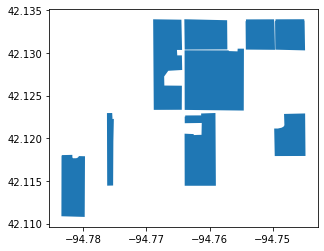

In [16]:
fields.plot()

### Notes

* the only consensus among researchers regarding NDVI interpretation seems to be the following:
    - NDVI < 0.2 - no vegetation present, 0.2 - 0.3 - very sparse or underdeveloped vegetation (f.e. summerized in https://iopscience.iop.org/article/10.1088/1755-1315/126/1/012112/pdf)
    - a healthy crop would expose values no less than 0.4 - 0.6 given moderate density and more than 0.6 given high density
    - what is considered as growth anomaly is usually derived from meticulous time-series analysis of the study area as it is dependant not only on a season and crop but also on the soil properties, climatic and geological conditions (f.e. https://www.hindawi.com/journals/tswj/2014/725326/ - farmers report stressed plants [poorly absorbing light] at NDVI score lower than 0.3 and 0.4 for different areas); extnsive time series analysis of several crops is described in https://www.researchgate.net/publication/228649433_A_Comparative_Analysis_of_Phenological_Curves_for_Major_Crops_in_Kansas, however, it is questionable if the same pattern will generalize to other areas (even if crop type is known)
    - in some studies with no ground truth labels/measures anomalies are defined as a deviation of 1.25 - 1.5 from NDVI mean over some period (usually 10 days), as an example study specifies https://journals.ametsoc.org/view/journals/wcas/4/4/wcas-d-11-00059_1.xml
    
* some anomalies are easily confused with pixel which should be a part of noisy pixels (f.e. borders), as can be seen of the first image plotted
* when zeros masked out, mean and standard deviation are very close either for image with removed noisy pixels or not
* July images [almost] always are skewed to the left (Moisture content for those is usually low and agrees only partually with plant stress detection)
* pixels 1 standard deviation and lower in value do not capture all visible anomalies but the most critical ones, more or less than that value results either in high noise or underdetection
* given said the previous statement, approach does not produce completely noise free

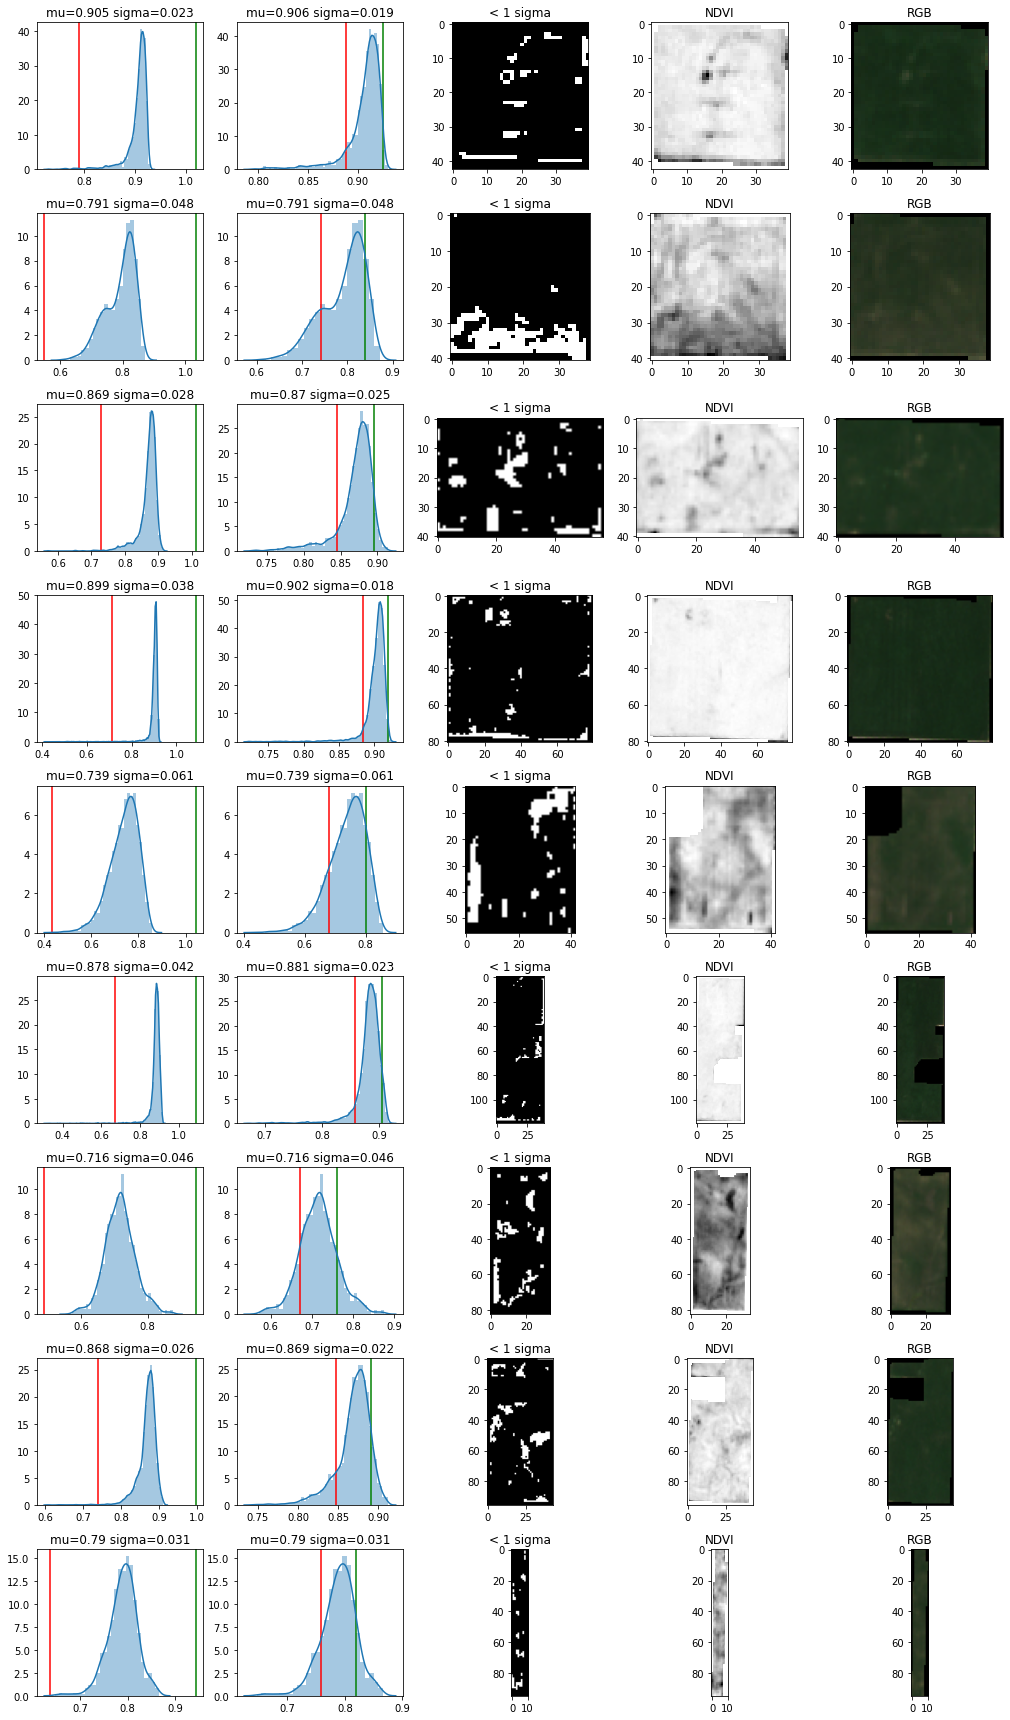

In [17]:
min_ndvi = 0.3 # https://iopscience.iop.org/article/10.1088/1755-1315/126/1/012112/pdf
num_clusters = 2
conf = 0.5
z_score = 5
z_score_anom = 1
rasters_to_stitch = []
p_bar = tqdm(fields.iterrows(), total=len(fields))
fig, ax = plt.subplots(len(p_bar), 5, figsize=(14, 24))
colors = {"Normal Growth": (0, 0, 0), "Anomaly": (182, 10, 28)}

for i, record in enumerate(p_bar):
    idx, row = record
    with rasterio.open(tci_tile) as src:
        tci_image, tfs = riomask.mask(
            src, [fields.to_crs(src.crs).iloc[idx].geometry], all_touched=False, crop=True)
        
    with rasterio.open(ndvi_path) as src:
        meta = src.meta
        ndvi_image, tfs = riomask.mask(
            src, [fields.to_crs(src.crs).iloc[idx].geometry], all_touched=False, crop=True)
        
    border, _  = cv2.findContours(
            np.where(ndvi_image[0]==0, 255, 0).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
    
    border_mask = cv2.drawContours(
        np.zeros(ndvi_image[0].shape), border, 0, 1, 2)
    
    ndvi_image = np.where(ndvi_image >= min_ndvi, ndvi_image, np.nan)
    mu, sigma = np.nanmean(ndvi_image), np.nanstd(ndvi_image)
    if mu < min_ndvi:
        print('No vegetation is observed, skipping')
    
    z1 = (mu-z_score*sigma, mu+z_score*sigma) # get rid of noise
    pure_ndvi = ndvi_image[0]
    pure_ndvi = pure_ndvi[pure_ndvi >= min_ndvi]
    pure_ndvi = pure_ndvi[(pure_ndvi >= z1[0]) & (pure_ndvi <= z1[1])]
    pure_mu, pure_sigma = pure_ndvi.mean(), pure_ndvi.std()
    z2 = (pure_mu-z_score_anom*pure_sigma, pure_mu+z_score_anom*pure_sigma) # find anomalies in "noise-free" image

    ax[i][0].axvline(z1[0], color='red');
    ax[i][0].axvline(z1[1], color='green');
    ax[i][0].set_title(f'mu={str(round(mu, 3))} sigma={str(round(sigma, 3))}');
    sns.distplot(ndvi_image.ravel(), ax=ax[i][0]);
    
    img_anom = ndvi_image[0]
    img_anom = np.where(img_anom < z2[0], 1, 0)
    img_anom = np.where(border_mask==1, 0, img_anom)
    raster_mask = np.where( (ndvi_image[0]>z1[0]) & (ndvi_image[0]<z1[1]), True, False )
    img_anom = np.where(raster_mask, img_anom, 0)
    
    ax[i][1].axvline(z2[0], color='red');
    ax[i][1].axvline(z2[1], color='green');
    
    ax[i][1].set_title(f'mu={str(round(pure_mu, 3))} sigma={str(round(pure_sigma, 3))}');
    sns.distplot(pure_ndvi.ravel(), ax=ax[i][1]);
    ax[i][2].imshow(img_anom, cmap='gray');
    ax[i][2].set_title(f'< {z_score_anom} sigma');
    ax[i][3].set_title(f'NDVI');
    ax[i][4].set_title(f'RGB');
    ax[i][3].imshow(ndvi_image[0], cmap='gray');
    ax[i][4].imshow(tci_image.transpose(1,2,0), cmap='gray');
    
    raster_path = ndvi_path.replace('_ndvi.tif', f'_field_{idx}.tif')
    assert raster_path != ndvi_path

    labels = []
    result_3c = img_anom.reshape(1, img_anom.shape[-2], img_anom.shape[-1])
    mask = np.zeros((ndvi_image[0].shape[-2], ndvi_image[0].shape[-1], 3)).astype(np.uint8)
    
    for ix, key in enumerate(colors.keys()):

        mask[result_3c[0]==ix] = colors[key]
        class_area = (np.where(mask[result_3c[0]==ix], 1, 0).sum()) / (3*10**4)

        labels.append({
            "color": ",".join(str(colors[key]).split(',')),
            "name": key,
            "area": round(class_area, 3)
        })
        
    meta['height'] = ndvi_image.shape[-2]
    meta['width'] = ndvi_image.shape[-1]
    meta['transform'] = tfs
    meta['dtype'] = rasterio.uint8
    
    meta.update(
        count=3,
        nodata=0,
        compress='lzw',
        photometric='RGB'
    )
    
    labels = json.dumps(labels)
    rasters_to_stitch.append(raster_path)
    
    if os.path.exists(raster_path):
        continue
    with rasterio.open(raster_path, 'w', **meta) as dst:

        dst.update_tags(start_date=START_DATE, 
                        end_date=END_DATE, 
                        request_id=str(REQUEST_ID),
                        # labels=labels,
                        name=f'Field anomalies')

        for i in range(mask.shape[-1]):
            dst.write(mask[:,:,i].astype(np.uint8), indexes=i+1)
            
    
    
plt.tight_layout();

In [ ]:
path = os.path.join(os.path.split(raster_path)[0], f'{REQUEST_ID}_merged.tif')
stitch_tiles(rasters_to_stitch, path)

In [ ]:
colors = ['red', 'blue']

def visualize_values(tci_imgs, ndvi_imgs, pred_imgs, colors=colors):
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    num_clusters = len(np.unique(pred_imgs)) - 1
    
    for cl in range(num_clusters):
        mask = np.where(pred_imgs[0]==cl+1, True, False)
        ndvi_series = [ndvi_imgs[i][mask] for i in range(len(ndvi_imgs))]
        ax[0].plot(ndvi_series, color=colors[cl], alpha=0.3);
        ax[1].plot(np.mean(ndvi_series, axis=-1), color=colors[cl], label=cl+1)
        ax[1].legend();
        
    plt.tight_layout();

In [ ]:
len(tci_images), len(pred_ndvi), len(results)

In [ ]:
pred_ndvi[0].shape

In [ ]:
r_len = len(b04_tiles)

In [ ]:
idx = 0
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
idx = 1
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
idx = 2
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
res2 = plot_images(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len], results[r_len*idx:r_len*idx+r_len])

In [ ]:
idx = 3
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
idx = 4
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
idx = 5
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
idx = 6
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
res2 = plot_images(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len], results[r_len*idx:r_len*idx+r_len])

In [ ]:
idx = 7
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
res2 = plot_images(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len], results[r_len*idx:r_len*idx+r_len])

In [ ]:
idx = 8
visualize_values(tci_images[r_len*idx:r_len*idx+r_len], ndvi_imgs[r_len*idx:r_len*idx+r_len], pred_ndvi[r_len*idx:r_len*idx+r_len])

In [ ]:
tci_sample = tci_images[r_len*idx:r_len*idx+r_len]
ndvi_sample = ndvi_imgs[r_len*idx:r_len*idx+r_len]
pred_sample = pred_ndvi[r_len*idx:r_len*idx+r_len]
result_sample = results[r_len*idx:r_len*idx+r_len]

res2 = plot_images(tci_sample, ndvi_sample, pred_sample, result_sample)

In [ ]:
remove_aux_rasters = True

if remove_aux_rasters:
    
    try:
        shutil.rmtree(tile_folder)
    except FileNotFoundError:
        print(f'Error removing directory {tile_folder}')
        
    for i in range(len(b04_tiles)):
        os.makedirs(f'{BASE}/results/dd/plant_stress/{REQUEST_ID}', exist_ok=True)
        ndvi_path = f'{BASE}/results/dd/plant_stress/{REQUEST_ID}/ndvi_{i}.tif'
        try:
            os.remove(ndvi_path)
        except FileNotFoundError:
            print(f'Error removing file {ndvi_path}')
            
    #for raster_path in rasters_to_stitch:
    #    try:
    #        os.remove(raster_path)
    #    except FileNotFoundError:
    #        print(f'Error removing file {raster_path}')

In [ ]:
stitch_preds = []
for file in os.listdir('/home/jovyan/work/results/dd/plant_stress/1011'):
    if file.endswith('.tif'):
        stitch_preds.append(os.path.join('/home/jovyan/work/results/dd/plant_stress/1011', file))
stitch_preds

In [ ]:
path = os.path.join(os.path.split(raster_path)[0], f'{REQUEST_ID}.tif')
stitch_tiles(stitch_preds, path)